In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [4]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
len(df_train)/len(df), len(df_val)/len(df), len(df), len(df_val)

(0.9642465458145908, 0.035753454185409164, 844338, 30188)

In [5]:
final_train = False

In [6]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))


$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}$


In [7]:
df_train.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitatio

In [8]:
df_train['Events'].head()

30188    20
30189    20
30190     0
30191    20
30192    20
Name: Events, dtype: int64

In [9]:
max_sales = df_train['Sales'].max()
df.loc[:, 'Sales_norm'] = df['Sales'].values/max_sales

In [10]:
df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales

/var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/ipykernel_2729/2193462401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
/var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/ipykernel_2729/2193462401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales


In [11]:
print('Train:')
print(get_metric(df_train['Sales_norm'], 
                 df_train['Sales_norm'].mean()))
print('Val:')
get_metric(df_val['Sales_norm'], 
           df_train['Sales_norm'].mean())

Train:
0.6371089378658443
Val:


0.5496723521813062

In [12]:
def get_mean_by_column(column, sales_str):
    group_means_dict = {}
    group_mean_list = []
    for col_value, group_df in df_train.groupby(column):
        group_mean =  group_df[group_df[sales_str] > 0][sales_str].mean()
        group_means_dict[col_value] = group_mean
        group_mean_list.append(group_mean)
    print('Train:', get_metric(df_train[sales_str], 
                               df_train[column].apply(group_means_dict.get)))
    print('Val:', get_metric(df_val[sales_str], 
                             df_val[column].apply(group_means_dict.get)))
    return group_means_dict, group_mean_list

In [13]:
# Media por store
_ = get_mean_by_column('Store', 'Sales_norm')

Train: 0.39609135212418334
Val: 0.3071746085338872


In [14]:
# Media por dia de la semana
_ = get_mean_by_column('DayOfWeek', 'Sales_norm')

Train: 0.600887492275444
Val: 0.506139218663547


In [15]:
# Media por numera de semana (1-52)
_ = get_mean_by_column('Week', 'Sales_norm')

Train: 0.6077405789213656
Val: 0.5171468581189805


In [16]:
_ = get_mean_by_column('Month', 'Sales_norm')

Train: 0.6326710739722307
Val: 0.5444650400703042


In [17]:
_ = get_mean_by_column('StateHoliday', 'Sales_norm')

Train: 0.637967104604832
Val: 0.5494193814701546


In [18]:
_ = get_mean_by_column('SchoolHoliday', 'Sales_norm')

Train: 0.6352131730794036
Val: 0.552288625488801


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

2023-02-22 10:02:23.493076: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [21]:
def get_keras_LR(X_columns, hidden_units=1):
    inputs = []
    activation = 'linear'
    if hidden_units>1:
        activation = 'relu'
    for i, col in enumerate(X_columns):
        inp = Input(shape=(X_train[i].shape[1],), name=f"{col}_input")
        inputs.append(inp)
    if len(X_columns)>1:
        concat_out = Concatenate()(inputs)
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(inputs[0])
    if hidden_units>1:
        dense_out = Dense(1, name='Dense_out')(dense_out)
    model = Model(inputs, dense_out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model


def get_embedings_NN(X_columns, hidden_units = 20, activation = 'relu'):
    embed_outs = []
    inputs = []
    for i, col in enumerate(X_columns):
        inp = Input(shape=(1,), name=f"{col}_input")
        inputs.append(inp)
        if col in embed_outs_dict:
            embed_out = Embedding(len(np.unique(X_train[i])), embed_outs_dict[col], name=f"{col}_embedding", mask_zero=False)(inp)
            out = Flatten(name=f"{col}_flatten")(embed_out)
            embed_outs.append(out)
        else:
            embed_outs.append(inp)
        
    if len(X_columns)>1:
        concat_out = Concatenate()(embed_outs)
        dense_out = Dense(hidden_units, activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, activation=activation)(out)
    out = Dense(1)(dense_out)
    model = Model(inputs, out)
    model.compile(optimizers.Adam(lr=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model

In [22]:
with_embed = True

embed_outs_dict = {'Store': 2, 'DayOfWeek': 2} #,  'Week': 2, 'Month': 2}
X_columns = list(embed_outs_dict.keys())# + ['BeforeStateHoliday_bool', 'Max_TemperatureC'] # ['Precipitationmm']

if final_train:
    X_train = np.hsplit(df[X_columns].values, len(X_columns))
    y_train = df['Sales_norm']
else:
    X_train = np.hsplit(df_train[X_columns].values, len(X_columns))
    y_train = df_train['Sales_norm']
    
X_val = np.hsplit(df_val[X_columns].values, len(X_columns))
X_test = np.hsplit(df_test[X_columns].values, len(X_columns))

if not with_embed:
    for i in range(len(X_train)):
        X_train[i] = to_categorical(X_train[i])
        X_val[i] = to_categorical(X_val[i])
        X_test[i] = to_categorical(X_test[i])

y_val = df_val['Sales_norm']

In [23]:
if with_embed:
    model = get_embedings_NN(X_columns)
else:
    model = get_keras_LR(X_columns, hidden_units=20)
model.summary()

2023-02-22 10:02:32.599762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Store_embedding (Embedding)    (None, 1, 2)         2230        ['Store_input[0][0]']            
                                                                                                  
 DayOfWeek_embedding (Embedding  (None, 1, 2)        14          ['DayOfWeek_input[0][0]']        
 )                                                                                            

In [24]:
# weights = model.get_weights()
# weights[0] = np.array(np.array(stores_mean_list).reshape(-1, 1))
# model.set_weights(weights)

In [25]:
from tensorflow.keras import callbacks

In [26]:
# model.evaluate(X_val, y_val)

In [27]:
# np.sqrt(0.0951)

In [28]:
epochs = 5
model.compile(optimizers.Adam(lr=0.001), loss='mse', metrics=[rmspe, 'mse'])
cbs = [callbacks.ReduceLROnPlateau(monitor='val_rmspe', mode='min', verbose=1, patience=2), callbacks.ModelCheckpoint('best_val_rmspe.hdf5', monitor='val_rmspe', mode='min', verbose=1, save_best_only=True)]
if final_train:
    model.fit(X_train, y_train, epochs=epochs, callbacks=cbs)
else:
    model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=cbs)

Epoch 1/5
25403/25443 [============================>.] - ETA: 0s - loss: 0.0019 - rmspe: 0.2832 - mse: 0.0019
Epoch 1: val_rmspe improved from inf to 0.21092, saving model to best_val_rmspe.hdf5
25443/25443 [==============================] - 35s 1ms/step - loss: 0.0019 - rmspe: 0.2832 - mse: 0.0019 - val_loss: 0.0014 - val_rmspe: 0.2109 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/5
25412/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2682 - mse: 0.0018
Epoch 2: val_rmspe did not improve from 0.21092
25443/25443 [==============================] - 31s 1ms/step - loss: 0.0018 - rmspe: 0.2682 - mse: 0.0018 - val_loss: 0.0014 - val_rmspe: 0.2165 - val_mse: 0.0014 - lr: 0.0010
Epoch 3/5
25413/25443 [============================>.] - ETA: 0s - loss: 0.0018 - rmspe: 0.2663 - mse: 0.0018
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_rmspe did not improve from 0.21092
25443/25443 [==============================] - 34s 1ms/step -

In [29]:
model.load_weights('best_val_rmspe.hdf5')

In [30]:
model.evaluate(X_train, y_train)

25443/25443 [==============================] - 26s 1ms/step - loss: 0.0017 - rmspe: 0.2276 - mse: 0.0017


[0.0017100154655054212, 0.22761180996894836, 0.0017100154655054212]

In [31]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 1s 892us/step - loss: 0.0013 - rmspe: 0.2065 - mse: 0.0013


[0.001306182355619967, 0.2065057009458542, 0.001306182355619967]

In [32]:
from matplotlib import pyplot as plt

In [33]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


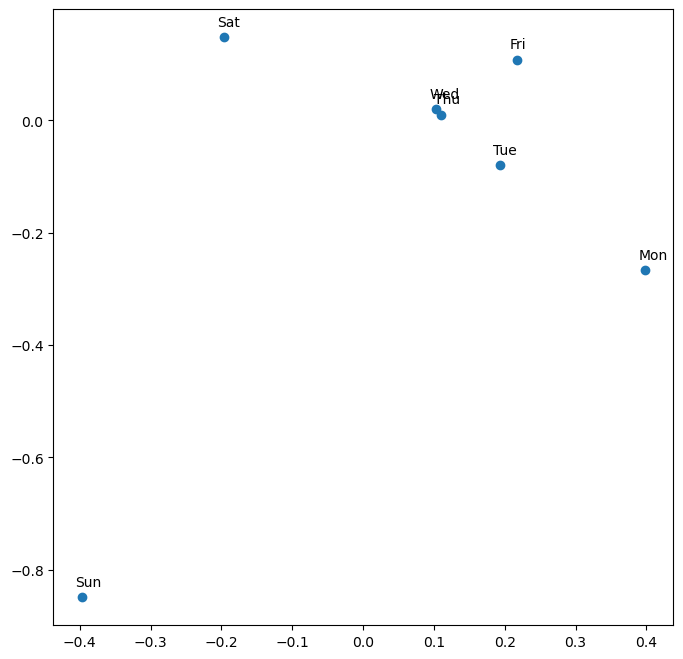

In [34]:
plot_embed('DayOfWeek_embedding', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(1115, 2)


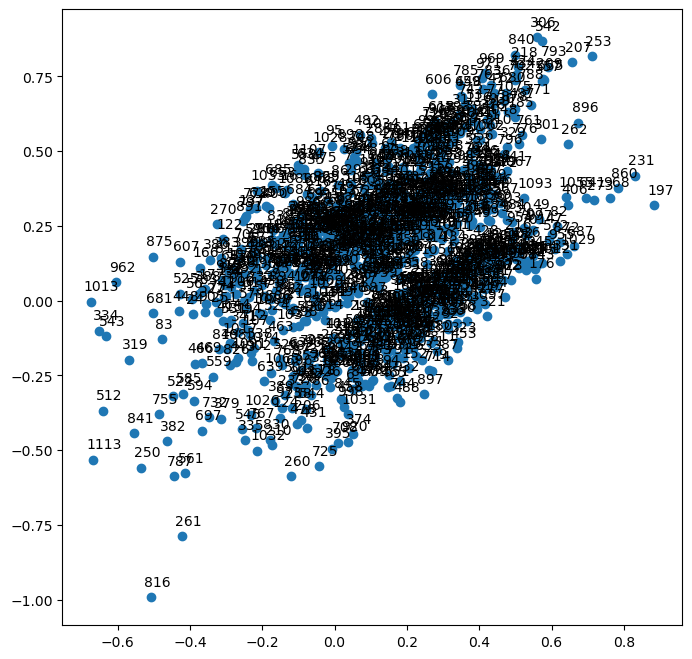

In [35]:
plot_embed('Store_embedding', list(range(1115)))

In [36]:
train_predictions = model.predict(X_train)*max_sales
get_metric(df_train['Sales'].values, train_predictions.reshape(-1))

25443/25443 [==============================] - 22s 858us/step


0.3026118066766774

In [37]:
test_predictions = model.predict(X_test)*max_sales
test_predictions[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 1s 1ms/step


In [38]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = test_predictions
sample_csv.head()

sample_csv.to_csv(f'submision_baseline_{"-".join(X_columns)}.csv', index=False)


In [39]:
#import beepy
#beepy.beep(sound=1)

from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 22/02/2023 10:06:18
